# Real Bogus Experiment

We used three subtraction techniques

Zackay's and Bramich's DIA algorithms, plus HOTPANTS source code.
All of them were applied on the same new--ref pair of images and the same source identification algorithm.
Each dataset is comparable... 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
sns.set_context(font_scale=1.2)

In [3]:
from sqlalchemy import create_engine
import pandas as pd

In [4]:
import os
plot_dir = os.path.abspath('./plots_three/.')
if not os.path.isdir(plot_dir):
    os.makedirs(plot_dir)

In [5]:
engine = create_engine('sqlite:///../RBpipeline/rbogus-dev.db')

Asking to the database for the undetected objects (False Negatives)

In [6]:
simulated = pd.read_sql_query("""SELECT * FROM Simulated""", engine)

In [7]:
und_z = pd.read_sql_query("""SELECT S.x, S.y, S.app_mag, S.image_id, U.simulated_id 
                             FROM Simulated S INNER JOIN Undetected U
                             ON S.id==U.simulated_id""", 
                          engine)

In [8]:
und_b = pd.read_sql_query("""SELECT S.x, S.y, S.app_mag, S.image_id, U.simulated_id 
                             FROM Simulated S INNER JOIN UndetectedOIS U
                             ON S.id==U.simulated_id""", 
                          engine)

In [9]:
und_h = pd.read_sql_query("""SELECT S.x, S.y, S.app_mag, S.image_id, U.simulated_id 
                             FROM Simulated S INNER JOIN UndetectedHOT U
                             ON S.id==U.simulated_id""", 
                          engine)

Querying the database to obtain the tables related to the detections.

In [10]:
dt_zps = pd.merge(pd.read_sql_table('Detected', engine),
                  pd.read_sql_query("""SELECT 
                                        Detected.id,
                                        Simulated.app_mag as sim_mag,
                                        Simulated.id as sim_id 
                                    FROM Detected
                                        LEFT JOIN Reals
                                            ON Detected.id==Reals.detected_id
                                        LEFT JOIN Simulated
                                            ON Simulated.id==Reals.simulated_id""", engine),
                                      on='id', suffixes=('',''))

dt_ois = pd.merge(pd.read_sql_table('DetectedOIS', engine),
                  pd.read_sql_query("""SELECT 
                                        DetectedOIS.id,
                                        Simulated.app_mag as sim_mag,
                                        Simulated.id as sim_id 
                                    FROM DetectedOIS
                                        LEFT JOIN RealsOIS
                                            ON DetectedOIS.id==RealsOIS.detected_id
                                        LEFT JOIN Simulated
                                            ON Simulated.id==RealsOIS.simulated_id""", engine),
                                      on='id', suffixes=('',''))

dt_hot = pd.merge(pd.read_sql_table('DetectedHOT', engine),
                  pd.read_sql_query("""SELECT 
                                        DetectedHOT.id,
                                        Simulated.app_mag as sim_mag,
                                        Simulated.id as sim_id 
                                    FROM DetectedHOT
                                        LEFT JOIN RealsHOT
                                            ON DetectedHOT.id==RealsHOT.detected_id
                                        LEFT JOIN Simulated
                                            ON Simulated.id==RealsHOT.simulated_id""", engine),
                                      on='id', suffixes=('',''))

In [11]:
# dt_ois.IS_REAL = dt_ois.IS_REAL.astype(int)
# dt_zps.IS_REAL = dt_zps.IS_REAL.astype(int)

### Some plots of simulated objects

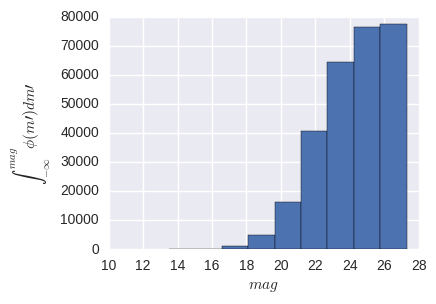

In [12]:
plt.figure(figsize=(4,3))
plt.hist(simulated['app_mag'], cumulative=True)
plt.xlabel(r'$mag$')
plt.ylabel(r'$\int_{-\infty}^{mag}\phi(m\prime)dm\prime$')
plt.savefig(os.path.join(plot_dir, 'lum_fun_simulated.png'), dpi=700)

### Analyzing the fraction of type of objects for each dataset

In [13]:
ois = [sum(dt_ois.IS_REAL), len(und_b), len(dt_ois.IS_REAL)-sum(dt_ois.IS_REAL)]
zps = [sum(dt_zps.IS_REAL), len(und_z), len(dt_zps.IS_REAL)-sum(dt_zps.IS_REAL)]
hot = [sum(dt_hot.IS_REAL), len(und_h), len(dt_hot.IS_REAL)-sum(dt_hot.IS_REAL)]
df2 = pd.DataFrame([zps, ois, hot], columns=['Real', 'False Neg', 'Bogus'])

In [14]:
print df2

    Real  False Neg   Bogus
0  28015      49379    8248
1  36029      41365   47481
2  31062      46332  174852


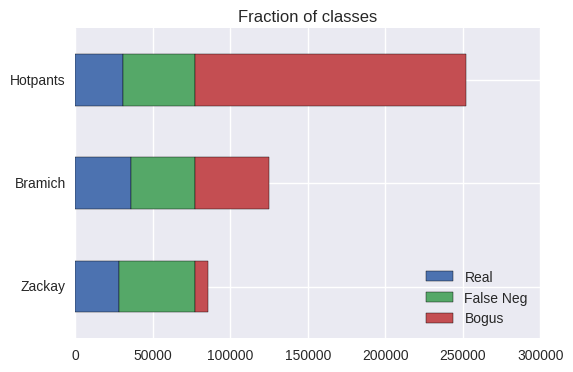

In [15]:
plt.figure(figsize=(4, 3))
df2.plot.barh(stacked=True)
plt.title('Fraction of classes')
plt.xscale('linear')
#plt.xlim(0, 260000)
plt.yticks([0,1,2], ['Zackay', 'Bramich', 'Hotpants'])

plt.legend(loc='lower right')
plt.savefig(os.path.join(plot_dir, 'fractions_classes.svg'), dpi=700)

## Magnitude offset

We need to calculate the magnitude offset to understand how to compare perfomances.

In [16]:
cx_zps = pd.read_sql_query(
"""SELECT 
  Detected.MAG_ISO, 
  Detected.MAG_AUTO, 
  Detected.MAG_APER,
  Simulated.app_mag as sim_mag,
  Simulated.id as sim_id 
FROM Detected
  INNER JOIN Reals
    ON Detected.id==Reals.detected_id
  INNER JOIN Simulated
    ON Simulated.id==Reals.simulated_id""", engine)

In [17]:
cx_ois = pd.read_sql_query(
"""SELECT 
  DetectedOIS.MAG_ISO,
  DetectedOIS.MAG_AUTO,
  DetectedOIS.MAG_APER,
  Simulated.app_mag as sim_mag,
  Simulated.id as sim_id 
FROM DetectedOIS
  INNER JOIN RealsOIS
    ON DetectedOIS.id==RealsOIS.detected_id
  INNER JOIN Simulated
    ON Simulated.id==RealsOIS.simulated_id""", engine)

In [18]:
cx_hot = pd.read_sql_query(
"""SELECT 
  DetectedHOT.MAG_ISO,
  DetectedHOT.MAG_AUTO,
  DetectedHOT.MAG_APER,
  Simulated.app_mag as sim_mag,
  Simulated.id as sim_id 
FROM DetectedHOT
  INNER JOIN RealsHOT
    ON DetectedHOT.id==RealsHOT.detected_id
  INNER JOIN Simulated
    ON Simulated.id==RealsHOT.simulated_id""", engine)

In [62]:
detections = pd.merge(cx_ois, cx_zps, how='outer', on='sim_id', suffixes=('_ois','_zps'))

In [63]:
detections.columns

Index([u'MAG_ISO_ois', u'MAG_AUTO_ois', u'MAG_APER_ois', u'sim_mag_ois',
       u'sim_id', u'MAG_ISO_zps', u'MAG_AUTO_zps', u'MAG_APER_zps',
       u'sim_mag_zps'],
      dtype='object')

In [64]:
detections = pd.merge(cx_hot, detections, how='outer', on='sim_id', suffixes=('_hot', '_'))

In [65]:
detections.columns

Index([u'MAG_ISO', u'MAG_AUTO', u'MAG_APER', u'sim_mag', u'sim_id',
       u'MAG_ISO_ois', u'MAG_AUTO_ois', u'MAG_APER_ois', u'sim_mag_ois',
       u'MAG_ISO_zps', u'MAG_AUTO_zps', u'MAG_APER_zps', u'sim_mag_zps'],
      dtype='object')

In [66]:
detections = detections.dropna()

In [67]:
detections['MAG_OFFSET_zps'] = detections['sim_mag_zps'] - detections['MAG_ISO_zps']
detections['MAG_OFFSET_ois'] = detections['sim_mag_ois'] - detections['MAG_ISO_ois']
detections['MAG_OFFSET'] = detections['sim_mag'] - detections['MAG_ISO']

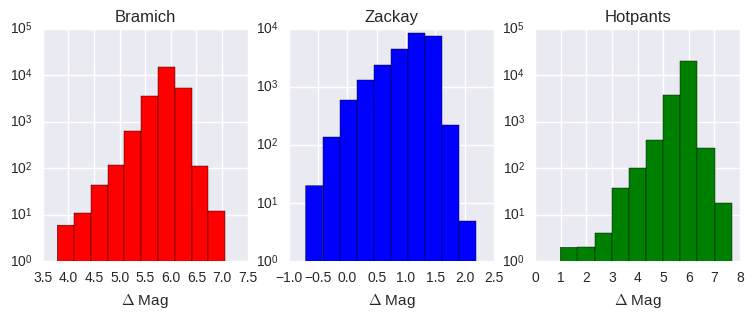

In [70]:
plt.figure(figsize=(9,3))
plt.subplot(131)
plt.hist(detections['MAG_OFFSET_ois'], log=True, color='red')
plt.title('Bramich')
plt.xlabel(r'$\Delta$ Mag')

plt.subplot(132)
plt.hist(detections['MAG_OFFSET_zps'], log=True, color='blue')
plt.xlabel(r'$\Delta$ Mag')
plt.title('Zackay')

plt.subplot(133)
plt.hist(detections['MAG_OFFSET'], log=True, color='green')
plt.xlabel(r'$\Delta$ Mag')
plt.title('Hotpants')
#plt.show()

plt.savefig(os.path.join(plot_dir, 'mag_offset.png'), format='png', dpi=700)

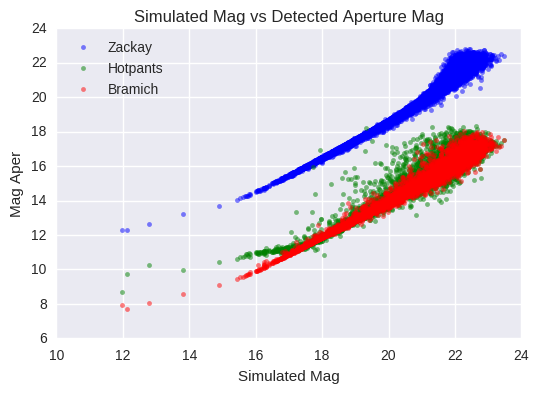

In [73]:
plt.figure(figsize=(6, 4))
plt.plot(detections['sim_mag_zps'], detections['MAG_ISO_zps'], 'b.', label='Zackay', alpha=0.5)
plt.plot(detections['sim_mag'], detections['MAG_ISO'], 'g.', label='Hotpants', alpha=0.5)
plt.plot(detections['sim_mag_ois'], detections['MAG_ISO_ois'], 'r.', label='Bramich', alpha=0.5)

plt.ylabel('Mag Aper')
plt.xlabel('Simulated Mag')
plt.title('Simulated Mag vs Detected Aperture Mag')
plt.legend(loc='best')
plt.savefig(os.path.join(plot_dir, 'aper_vs_simulated_mag.png'), format='png', dpi=700)

In [74]:
print 'Mean magniutde difference for Zackay is {}'.format(detections.MAG_OFFSET_zps.mean())
print 'Mean magniutde difference for Bramich is {}'.format(detections.MAG_OFFSET_ois.mean())
print 'Mean magniutde difference for Hotpans is {}'.format(detections.MAG_OFFSET.mean())

Mean magniutde difference for Zackay is 1.08174193262
Mean magniutde difference for Bramich is 5.92012586511
Mean magniutde difference for Hotpans is 5.85617060836


In [75]:
dt_ois['mag'] = dt_ois['MAG_ISO'] + detections.MAG_OFFSET_ois.mean()
dt_zps['mag'] = dt_zps['MAG_ISO'] + detections.MAG_OFFSET_zps.mean()
dt_hot['mag'] = dt_hot['MAG_ISO'] + detections.MAG_OFFSET.mean()

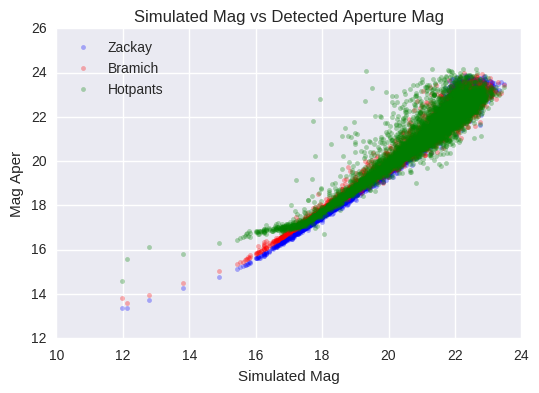

In [76]:
plt.plot(detections['sim_mag_zps'], 
         detections['MAG_ISO_zps'] + detections.MAG_OFFSET_zps.mean(),
         'b.', label='Zackay', alpha=0.3)
plt.plot(detections['sim_mag_ois'],
         detections['MAG_ISO_ois'] + detections.MAG_OFFSET_ois.mean(),
         'r.', label='Bramich', alpha=0.3)
plt.plot(detections['sim_mag'],
         detections['MAG_ISO'] + detections.MAG_OFFSET.mean(),
         'g.', label='Hotpants', alpha=0.3)

plt.ylabel('Mag Aper')
plt.xlabel('Simulated Mag')
plt.title('Simulated Mag vs Detected Aperture Mag')
plt.legend(loc='best')

plt.savefig(os.path.join(plot_dir, 'corrected_aper_vs_simulated_mag.png'), format='png', dpi=900)

In [77]:
dt_ois['mu'] = dt_ois.mag/(dt_ois.A_IMAGE*dt_ois.B_IMAGE)
dt_zps['mu'] = dt_zps.mag/(dt_zps.A_IMAGE*dt_zps.B_IMAGE)
dt_hot['mu'] = dt_hot.mag/(dt_hot.A_IMAGE*dt_hot.B_IMAGE)

In [78]:
bogus_b = dt_ois[dt_ois.IS_REAL==False]
reals_b = dt_ois[dt_ois.IS_REAL==True]

bogus_z = dt_zps[dt_zps.IS_REAL==False]
reals_z = dt_zps[dt_zps.IS_REAL==True]

bogus_h = dt_hot[dt_hot.IS_REAL==False]
reals_h = dt_hot[dt_hot.IS_REAL==True]

## Luminosity function 

Bogus, Real, and FN luminosity functions.


In [108]:
reals_b.mag.values

array([ 21.42582587,  17.21822587,  20.96512587, ...,  21.52272587,
        23.38282587,  23.00382587])

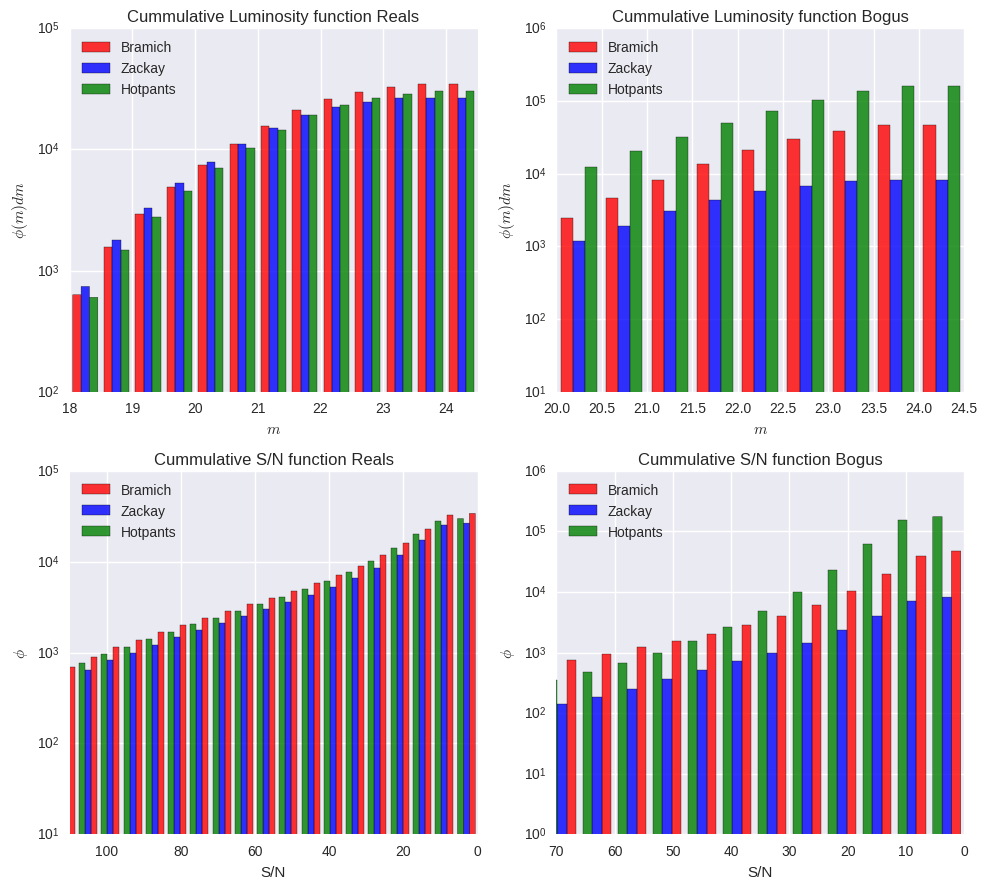

In [133]:
plt.figure(figsize=(10,9))

#magnitude bins
bins = np.arange(18, 25, 0.5)

plt.subplot(221)
plt.hist([reals_b.mag.values, reals_z.mag.values, reals_h.mag.values], 
         label=['Bramich', 'Zackay', 'Hotpants'], 
         color=['red', 'blue', 'green'], log=True, 
         alpha=0.8, bins=bins, normed=False, cumulative=True)

# plt.hist(reals_b.mag, alpha=0.5, bins=bins, #shade=True, 
#             cumulative=True, label='Bramich', color='red')
# plt.hist(reals_z.mag, alpha=0.5, bins=bins, #shade=True, 
#             cumulative=True, label='Zackay', color='blue')
# plt.hist(reals_h.mag, alpha=0.5, bins=bins, #shade=True, 
#             cumulative=True, label='Hotpants', color='green')

plt.xlim(18, 24.5)
plt.title('Cummulative Luminosity function Reals')
plt.ylabel(r'$\phi(m)dm$')
plt.legend(loc='best')
plt.xlabel(r'$m$')

plt.subplot(222)
plt.hist([bogus_b.mag.values, bogus_z.mag.values, bogus_h.mag.values], 
         label=['Bramich', 'Zackay', 'Hotpants'], 
         color=['red', 'blue', 'green'], log=True,
         alpha=0.8, bins=bins, normed=False, cumulative=True)

# plt.hist(bogus_b.mag, alpha=0.5, bins=bins, #shade=True, 
#             cumulative=True, label='Bramich', color='red')
# plt.hist(bogus_z.mag, alpha=0.5, bins=bins, #shade=True, 
#             cumulative=True, label='Zackay', color='blue')

plt.xlim(20, 24.5)
plt.ylabel(r'$\phi(m)dm$')
plt.legend(loc='best')
plt.xlabel(r'$m$')
plt.title('Cummulative Luminosity function Bogus')

#signal to noise bins
bins = np.arange(0, 140, 6)

plt.subplot(223)
plt.hist([(reals_b.FLUX_ISO/reals_b.FLUXERR_ISO).values, 
          (reals_z.FLUX_ISO/reals_z.FLUXERR_ISO).values,
          (reals_h.FLUX_ISO/reals_h.FLUXERR_ISO).values], 
         label=['Bramich', 'Zackay', 'Hotpants'], 
         color=['red', 'blue', 'green'], log=True, 
         alpha=0.8, bins=bins, normed=False, cumulative=-1)

# plt.hist(reals_b.FLUX_ISO/reals_b.FLUXERR_ISO,  bins=bins, #shade=True, 
#             label='Bramich', color='red', cumulative=-1, alpha=0.4)
# plt.hist(reals_z.FLUX_ISO/reals_z.FLUXERR_ISO,  bins=bins, #shade=True, 
#          label='Zackay', color='blue', cumulative=-1, alpha=0.4)

plt.xlim(110, 0)
plt.title('Cummulative S/N function Reals')
plt.legend(loc='best')
plt.ylabel(r'$\phi$')
plt.xlabel('S/N')

plt.subplot(224)
plt.hist([(bogus_b.FLUX_ISO/bogus_b.FLUXERR_ISO).values, 
          (bogus_z.FLUX_ISO/bogus_z.FLUXERR_ISO).values,
          (bogus_h.FLUX_ISO/bogus_h.FLUXERR_ISO).values], 
         label=['Bramich', 'Zackay', 'Hotpants'], 
         color=['red', 'blue', 'green'], log=True, 
         alpha=0.8, bins=bins, normed=False, cumulative=-1)

# plt.hist(bogus_b.FLUX_ISO/bogus_b.FLUXERR_ISO, bins=bins,  #shade=True, 
#          label='Bramich', color='red', cumulative=-1, alpha=0.5)
# plt.hist(bogus_z.FLUX_ISO/bogus_z.FLUXERR_ISO, bins=bins,  #shade=True, 
#          label='Zackay', color='blue', cumulative=-1, alpha=0.5)

plt.xlim(70, 0)
plt.title('Cummulative S/N function Bogus')
plt.ylabel(r'$\phi$')
plt.legend(loc='best')
plt.xlabel('S/N')

plt.tight_layout()
#plt.show()

plt.savefig(os.path.join(plot_dir, 'luminosities_functions.png'), format='png', dpi=700)

## What about the FN?

We should check on the lost objects.

### Luminosity function for Undetected

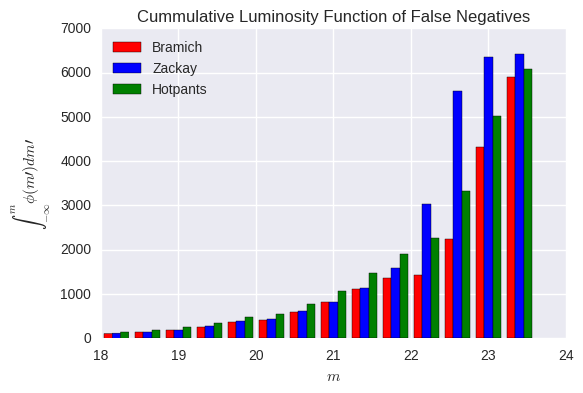

In [139]:
bins = np.arange(18, 24, 0.4)

plt.figure()
# sns.kdeplot(und_z.app_mag, cumulative=True, shade=True, color='blue', label='Zackay')
# sns.kdeplot(und_b.app_mag, cumulative=True, shade=True, color='red', label='Bramich')
# plt.hist(und_z.app_mag, cumulative=True, bins=bins,
#          #histtype='stepfilled', 
#          color='blue', label='Zackay', alpha=0.5)
# plt.hist(und_b.app_mag, cumulative=True, bins=bins, 
#          #histtype='stepfilled', 
#          color='red', label='Bramich', alpha=0.5)
plt.hist([und_b.app_mag, und_z.app_mag, und_h.app_mag],
         color=['red', 'blue', 'green'],
         label=['Bramich', 'Zackay', 'Hotpants'], 
         bins=bins)

plt.legend(loc='upper left')
plt.ylabel(r'$\int_{-\infty}^{m}\phi(m\prime)dm\prime$')
plt.xlabel(r'$m$')
plt.title('Cummulative Luminosity Function of False Negatives')
#plt.xlim(21., 23.1)
#plt.show()

plt.savefig(os.path.join(plot_dir, 'lum_function_FNegatives.png'), format='png', dpi=700)

### Are there coincident objects?

In [140]:
und_b.columns

Index([u'x', u'y', u'app_mag', u'image_id', u'simulated_id'], dtype='object')

In [141]:
und_z.columns

Index([u'x', u'y', u'app_mag', u'image_id', u'simulated_id'], dtype='object')

In [142]:
und_h.columns

Index([u'x', u'y', u'app_mag', u'image_id', u'simulated_id'], dtype='object')

In [250]:
und_mix = pd.merge(left=und_b, right=und_z, on='simulated_id', 
                   suffixes=('_b', '_z'), how='outer', indicator='row_from')

In [251]:
und_mix.columns

Index([         u'x_b',          u'y_b',    u'app_mag_b',   u'image_id_b',
       u'simulated_id',          u'x_z',          u'y_z',    u'app_mag_z',
         u'image_id_z',     u'row_from'],
      dtype='object')

In [266]:
magnitudes_und = pd.DataFrame({'mag_both' : und_mix[und_mix.row_from=='both'].app_mag_b,
                               'mag_onlyb': und_mix[und_mix.row_from=='left_only'].app_mag_b,
                               'mag_onlyz': und_mix[und_mix.row_from=='right_only'].app_mag_z})

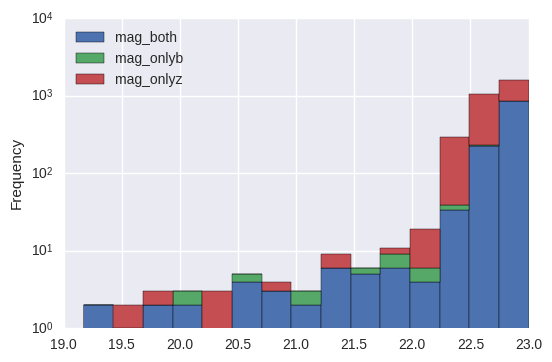

In [267]:
magnitudes_und.plot.hist(stacked=True, bins=15, log=True)

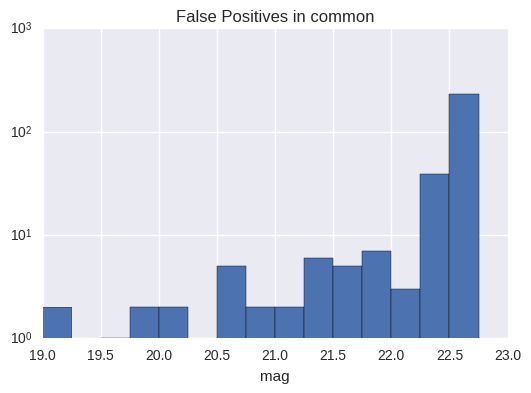

In [247]:
bins = np.arange(19, 23., 0.25)
plt.hist(und_mix.app_mag_b[und_mix.row_from=='both'], bins=bins, log=True)
plt.title('False Positives in common')
plt.xlabel('mag')
plt.xlim(19, 23.)
plt.show()

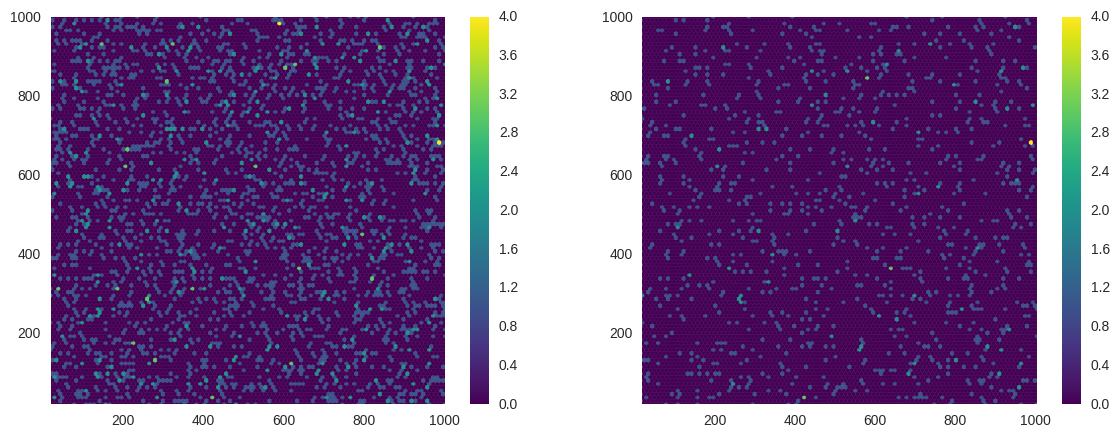

In [28]:
plt.figure(figsize=(14,5))
plt.subplot(121)
plt.xlabel
plt.hexbin(und_z.x, und_z.y, cmap='viridis')
plt.colorbar()
plt.subplot(122)
plt.hexbin(und_b.x, und_b.y, cmap='viridis')
plt.colorbar()

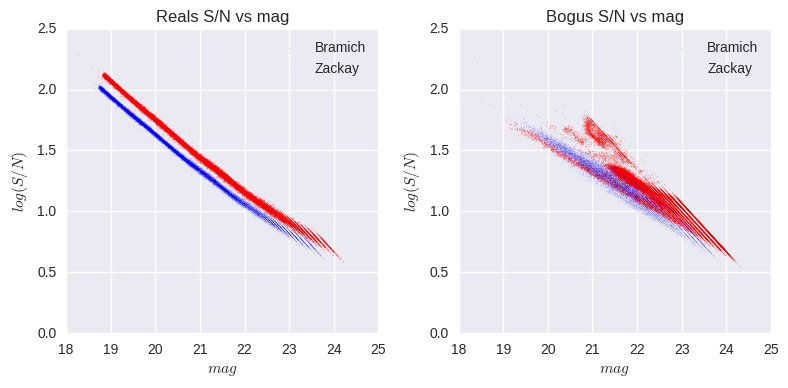

In [29]:
plt.figure(figsize=(8, 4))
plt.subplot(121)
plt.title('Reals S/N vs mag')
plt.scatter(reals_b.mag, 
         np.log10(reals_b.FLUX_ISO/reals_b.FLUXERR_ISO),
         s=np.log10(reals_b.FLUXERR_ISO), linewidths=0.001, 
        c='r', marker='.', alpha=0.3, label='Bramich')
plt.scatter(reals_z.mag, 
         np.log10(reals_z.FLUX_ISO/reals_z.FLUXERR_ISO), 
         s=np.log10(reals_z.FLUXERR_ISO), linewidths=0.001,
         c='b', marker='.', alpha=0.3, label='Zackay')
plt.xlim(18,25)
#plt.ylim(0, 220)
plt.xlabel(r'$mag$')
plt.ylabel(r'$log(S/N)$')
plt.legend(loc='best')
plt.subplot(122)
plt.title('Bogus S/N vs mag')
plt.scatter(bogus_b.mag,
            np.log10(bogus_b.FLUX_ISO/bogus_b.FLUXERR_ISO),
            s=np.log10(bogus_b.FLUXERR_ISO), linewidths=0.001,
            c='r', marker='.', alpha=0.3, label='Bramich') 
plt.scatter(bogus_z.mag,
            np.log10(bogus_z.FLUX_ISO/bogus_z.FLUXERR_ISO),
            s=np.log10(bogus_z.FLUXERR_ISO), linewidths=0.001,
            c='b', marker='.', alpha=0.3, label='Zackay')
plt.xlim(18,25)
#plt.ylim(0, 220)
plt.xlabel(r'$mag$')
plt.ylabel(r'$log(S/N)$')
plt.legend(loc='best')
plt.tight_layout()
plt.savefig(os.path.join(plot_dir, 'signal_to_noise_vs_mag.png'), format='png', dpi=700)

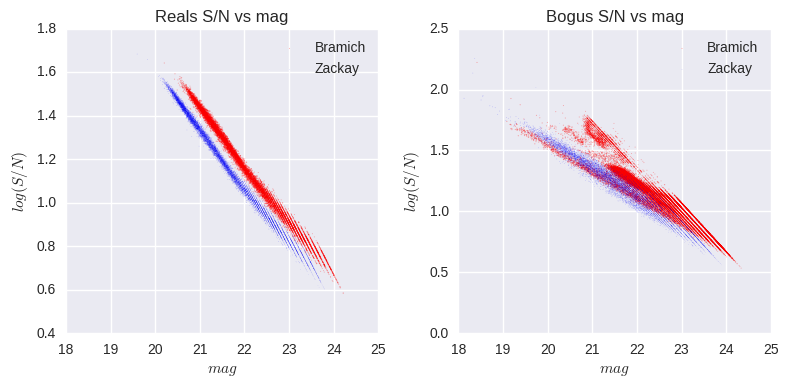

In [30]:
low_cstar_b = reals_b.CLASS_STAR < 0.005
low_cstar_z = reals_z.CLASS_STAR < 0.005

plt.figure(figsize=(8, 4))
plt.subplot(121)
plt.title('Reals S/N vs mag')
plt.scatter(reals_b.mag[low_cstar_b], 
         np.log10(reals_b.FLUX_ISO/reals_b.FLUXERR_ISO)[low_cstar_b],
         s=np.log10(reals_b.FLUXERR_ISO)[low_cstar_b], linewidths=0.001, 
        c='r', marker='.', alpha=0.3, label='Bramich')
plt.scatter(reals_z.mag[low_cstar_z], 
         np.log10(reals_z.FLUX_ISO/reals_z.FLUXERR_ISO)[low_cstar_z], 
         s=np.log10(reals_z.FLUXERR_ISO)[low_cstar_z], linewidths=0.001,
         c='b', marker='.', alpha=0.3, label='Zackay')
plt.xlim(18,25)
#plt.ylim(0, 220)
plt.xlabel(r'$mag$')
plt.ylabel(r'$log(S/N)$')
plt.legend(loc='best')


plt.subplot(122)
plt.title('Bogus S/N vs mag')
plt.scatter(bogus_b.mag,
            np.log10(bogus_b.FLUX_ISO/bogus_b.FLUXERR_ISO),
            s=np.log10(bogus_b.FLUXERR_ISO), linewidths=0.001,
            c='r', marker='.', alpha=0.3, label='Bramich') 
plt.scatter(bogus_z.mag,
            np.log10(bogus_z.FLUX_ISO/bogus_z.FLUXERR_ISO),
            s=np.log10(bogus_z.FLUXERR_ISO), linewidths=0.001,
            c='b', marker='.', alpha=0.3, label='Zackay')
plt.xlim(18,25)
#plt.ylim(0, 220)
plt.xlabel(r'$mag$')
plt.ylabel(r'$log(S/N)$')
plt.legend(loc='best')
plt.tight_layout()
plt.savefig(os.path.join(plot_dir, 'signal_to_noise_vs_mag.png'), format='png', dpi=700)

Need to calculate mean and dispersion of log10(S/N) on magnitude bins.

In [31]:
def binning(data, bins, step):
    meanlogsn = []
    stdvlogsn = []
    
    for abin in bins:
        fdata = data[(data.mag < abin + step) * (data.mag >= abin)]
        meanlogsn.append(np.mean(np.log10(fdata.FLUX_ISO/fdata.FLUXERR_ISO)))
        stdvlogsn.append(np.std( np.log10(fdata.FLUX_ISO/fdata.FLUXERR_ISO)))
    return meanlogsn, stdvlogsn

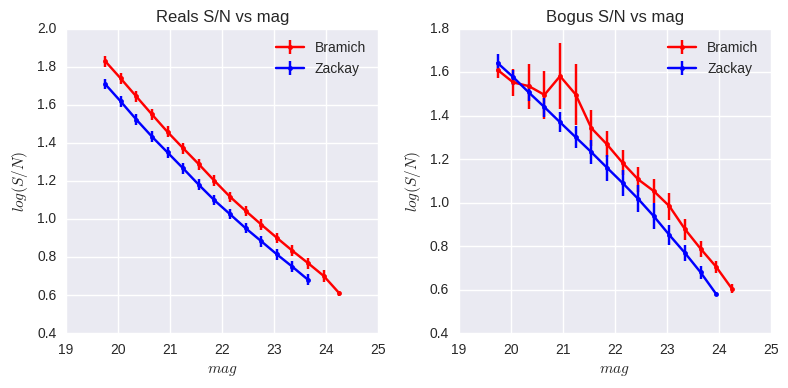

In [42]:
step = 0.3
bins = np.arange(19.6, 24.4, step)

plt.figure(figsize=(10, 5))
plt.subplot(121)
plt.title('Reals S/N vs mag')
means, stds = binning(reals_b, bins, step)
plt.errorbar(x=bins + step/2., 
             y=means,
             yerr=stds, 
             #linewidths=0.001, 
             c='r', marker='.', alpha=1, label='Bramich')

means, stds = binning(reals_z, bins, step)
plt.errorbar(x=bins + step/2., 
             y=means,
             yerr=stds, 
             c='b', marker='.', alpha=1, label='Zackay')
plt.xlim(19,25)
#plt.ylim(0, 220)
plt.xlabel(r'$mag$')
plt.ylabel(r'$log(S/N)$')
plt.legend(loc='best')

plt.subplot(122)
plt.title('Bogus S/N vs mag')
means, stds = binning(bogus_b, bins, step)
plt.errorbar(x=bins + step/2., 
             y=means,
             yerr=stds, 
            #linewidths=0.001,
            c='r', marker='.', alpha=1, label='Bramich') 
means, stds = binning(bogus_z, bins, step)
plt.errorbar(x=bins + step/2., 
             y=means,
             yerr=stds, 
             #linewidths=0.001,
             c='b', marker='.', alpha=1, label='Zackay')
plt.xlim(19,25)
#plt.ylim(0, 220)
plt.xlabel(r'$mag$')
plt.ylabel(r'$log(S/N)$')
plt.legend(loc='best')
plt.tight_layout()
plt.savefig(os.path.join(plot_dir, 'signal_to_noise_vs_mag_binned.png'), format='png', dpi=700)

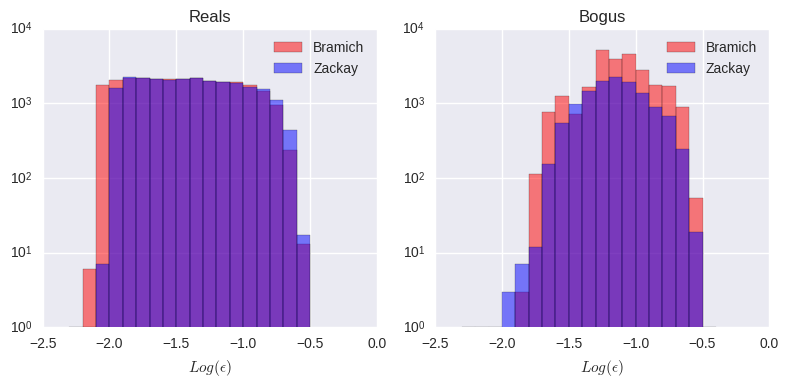

In [33]:
bins=np.arange(-2.5, 0., 0.1)
plt.figure(figsize=(8, 4))
plt.subplot(121)
plt.title('Reals')
plt.hist(np.log10(reals_b.MAGERR_ISO[reals_b.MAG_ISO < 30]), bins=bins,
         log=True, alpha=0.5, color='red', label='Bramich')
plt.hist(np.log10(reals_z.MAGERR_ISO[reals_z.MAG_ISO < 30]), bins=bins,
         log=True, alpha=0.5, color='blue', label='Zackay')
plt.xlabel(r'$Log(\epsilon)$')
plt.xlim(-2.5, 0.)
plt.ylim(0, 10000)
plt.legend(loc='best')

plt.subplot(122)
plt.title('Bogus')
plt.hist(np.log10(bogus_b.MAGERR_ISO[bogus_b.MAG_ISO < 30]), bins=bins,
         log=True, alpha=0.5, color='red', label='Bramich')
plt.hist(np.log10(bogus_z.MAGERR_ISO[bogus_z.MAG_ISO < 30]), bins=bins,
         log=True, alpha=0.5, color='blue', label='Zackay')
plt.xlabel(r'$Log(\epsilon)$')
plt.xlim(-2.5, 0.)
plt.ylim(0, 10000)
plt.legend(loc='best')

plt.tight_layout()
plt.savefig(os.path.join(plot_dir, 'mag_errors.png'), format='png', dpi=700)

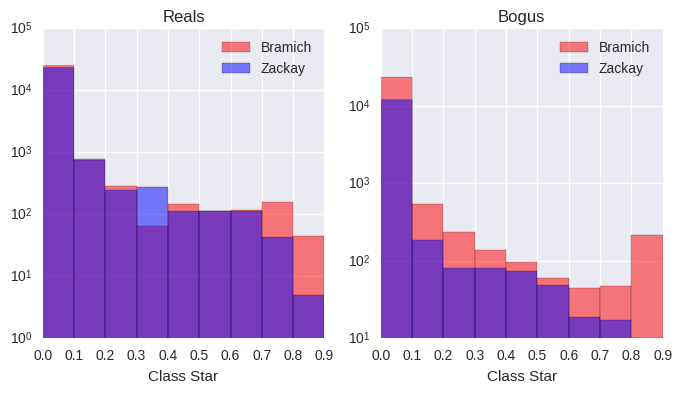

In [34]:
bins = np.arange(0, 1., 0.1)
plt.figure(figsize=(8, 4))
plt.subplot(121)
plt.title('Reals')
plt.hist(reals_b.CLASS_STAR, log=True, bins=bins, alpha=0.5, color='red', label='Bramich')
plt.hist(reals_z.CLASS_STAR, log=True, bins=bins, alpha=0.5, color='blue', label='Zackay')
plt.xlabel(r'Class Star')
plt.legend(loc='best')
plt.subplot(122)
plt.title('Bogus')
plt.hist(bogus_b.CLASS_STAR, log=True, bins=bins, alpha=0.5, color='red', label='Bramich')
plt.hist(bogus_z.CLASS_STAR, log=True, bins=bins, alpha=0.5, color='blue', label='Zackay')
plt.xlabel(r'Class Star')
plt.legend(loc='best')

plt.savefig(os.path.join(plot_dir, 'class_star_hist.png'), format='png', dpi=700)

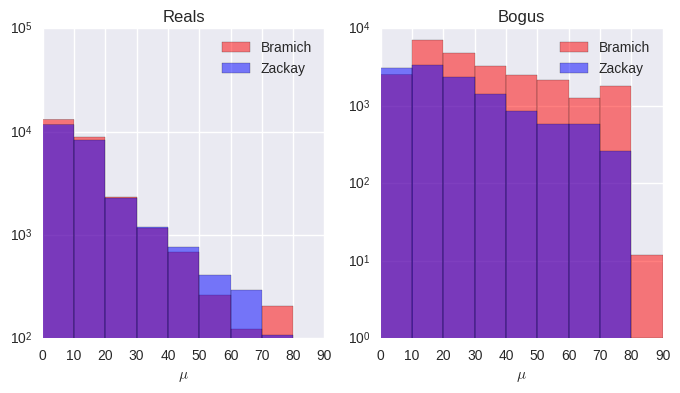

In [35]:
bins = np.arange(0, 100, 10)

plt.figure(figsize=(8, 4))
plt.subplot(121)
plt.title('Reals')
plt.hist(reals_b.mu, bins=bins, log=True, alpha=0.5, color='red', label='Bramich')
plt.hist(reals_z.mu, bins=bins, log=True, alpha=0.5, color='blue', label='Zackay')
plt.xlabel(r'$\mu$')
plt.legend(loc='best')
plt.subplot(122)
plt.title('Bogus')
plt.hist(bogus_b.mu, bins=bins, log=True, alpha=0.5, color='red', label='Bramich')
plt.hist(bogus_z.mu, bins=bins, log=True, alpha=0.5, color='blue', label='Zackay')
plt.xlabel(r'$\mu$')
plt.legend(loc='best')

plt.savefig(os.path.join(plot_dir, 'mu_hist.png'), format='png', dpi=700)

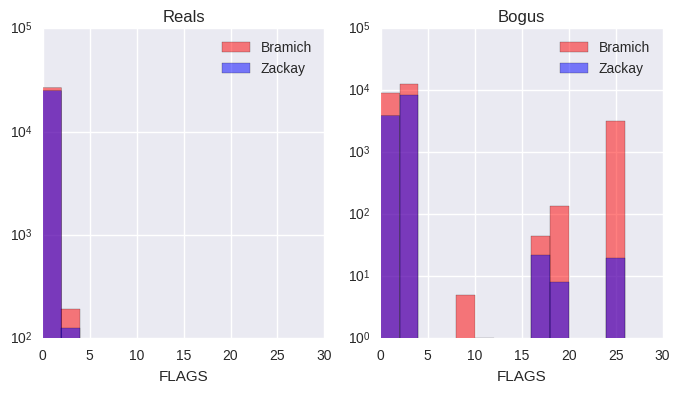

In [36]:
bins = np.arange(0, 28, 2)

plt.figure(figsize=(8, 4))
plt.subplot(121)
plt.title('Reals')
plt.hist(reals_b.FLAGS, bins=bins, log=True, alpha=0.5, color='red', label='Bramich')
plt.hist(reals_z.FLAGS, bins=bins, log=True, alpha=0.5, color='blue', label='Zackay')
plt.xlabel(r'FLAGS')
plt.legend(loc='best')
plt.subplot(122)
plt.title('Bogus')
plt.hist(bogus_b.FLAGS, bins=bins, log=True, alpha=0.5, color='red', label='Bramich')
plt.hist(bogus_z.FLAGS, bins=bins, log=True, alpha=0.5, color='blue', label='Zackay')
plt.xlabel(r'FLAGS')
plt.legend(loc='best')

plt.savefig(os.path.join(plot_dir, 'flags_hist.png'), format='png', dpi=700)

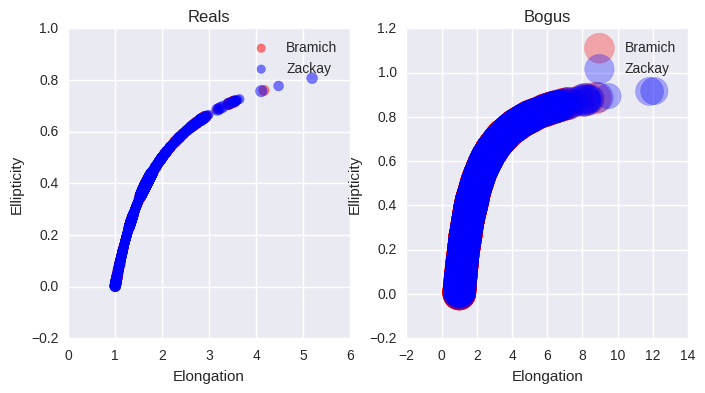

In [37]:
plt.figure(figsize=(8, 4))
plt.subplot(121)
plt.title('Reals')
plt.scatter(reals_b.ELONGATION, reals_b.ELLIPTICITY, s=reals_b.mu,
            alpha=0.5, color='red', label='Bramich')
plt.scatter(reals_z.ELONGATION, reals_z.ELLIPTICITY, s=reals_z.mu,
            alpha=0.5, color='blue', label='Zackay')
plt.xlabel(r'Elongation')
plt.ylabel(r'Ellipticity')
plt.legend(loc='best')
# plt.xlim(0, 16)
# plt.ylim(-0.1, 1.3)

plt.subplot(122)
plt.title('Bogus')
plt.scatter(bogus_b.ELONGATION, bogus_b.ELLIPTICITY, s=bogus_b.mag**2,
            alpha=0.3, color='red', label='Bramich')
plt.scatter(bogus_z.ELONGATION, bogus_z.ELLIPTICITY, s=bogus_z.mag**2,
            alpha=0.3, color='blue', label='Zackay')
plt.xlabel(r'Elongation')
plt.ylabel(r'Ellipticity')
plt.legend(loc='best')

plt.savefig(os.path.join(plot_dir, 'ellipticty_vs_elongation.png'), format='png', dpi=700)

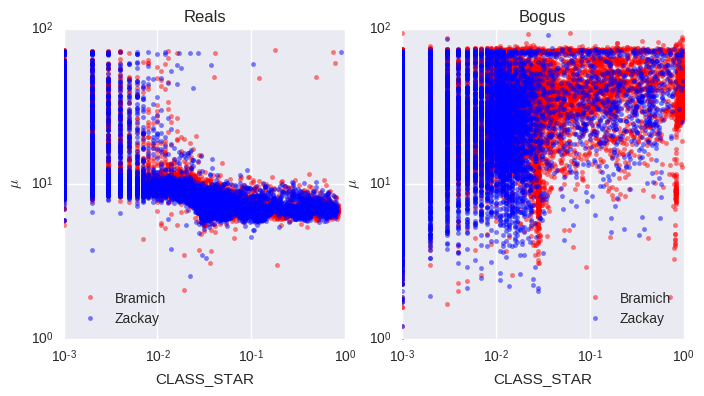

In [38]:
plt.figure(figsize=(8, 4))
plt.subplot(121)
plt.title('Reals')
plt.plot(reals_b.CLASS_STAR, reals_b.mu, '.',
            alpha=0.5, color='red', label='Bramich')
plt.plot(reals_z.CLASS_STAR, reals_z.mu, '.', 
            alpha=0.5, color='blue', label='Zackay')

# plt.xlim(0, 16)
# plt.ylim(-0.1, 1.3)
plt.loglog()
plt.xlabel(r'CLASS_STAR')
plt.ylabel(r'$\mu$')
plt.legend(loc='best')

plt.subplot(122)
plt.title('Bogus')
plt.plot(bogus_b.CLASS_STAR, bogus_b.mu, '.',
            alpha=0.5, color='red', label='Bramich')
plt.plot(bogus_z.CLASS_STAR, bogus_z.mu, '.', 
            alpha=0.5, color='blue', label='Zackay')
plt.ylim(1, 100.)
plt.loglog()
plt.xlabel(r'CLASS_STAR')
plt.ylabel(r'$\mu$')
plt.legend(loc='best')


## Checking on the outliers

In [58]:
from astropy.nddata.utils import extract_array
from astropy.io import fits


def get_patch_bramich(x, y, image_id):
    """Gets data from a row of a table, from a bramich subtracted source, and uses
    its coordinates to extract a patch from the image.
    """
    size = (14, 14)
    
    path = os.path.join('/home/bruno/Data/RBpipeline/images', 
                        'img'+str(image_id).zfill(5))
    filepath = os.path.join(path, 'diff_ois.fits')
    
    pixdata = fits.getdata(filepath)
    
    patch = extract_array(pixdata, size, (x, y))
    
    return patch
    
    
def get_patch_zackay(x, y, image_id):
    """Gets data from a row of a table, from a bramich subtracted source, and uses
    its coordinates to extract a patch from the image.
    """
    size = (14, 14)
    
    path = os.path.join('/home/bruno/Data/RBpipeline/images', 
                        'img'+str(image_id).zfill(5))
    filepath = os.path.join(path, 'diff.fits')
    
    pixdata = fits.getdata(filepath)
    
    patch = extract_array(pixdata, size, (x, y))
    
    return patch
    

In [59]:
outliers_b = bogus_b[bogus_b.CLASS_STAR > .97]

In [60]:
outliers_b

,id,NUMBER,FLUX_ISO,FLUXERR_ISO,MAG_ISO,MAGERR_ISO,FLUX_APER,FLUXERR_APER,MAG_APER,MAGERR_APER,...,DELTAY,RATIO,ROUNDNESS,PEAK_CENTROID,IS_REAL,image_id,sim_mag,sim_id,mag,mu
837,838,70,8927.6490,217.8098,15.1232,0.0265,7263.1340,248.9774,15.3472,0.0372,...,3.0,1.000000,1.094891,0.467779,False,11,NaN,NaN,21.04994,28.453555
1194,1195,51,4855.2450,196.7043,15.7845,0.0440,4358.5080,212.1612,15.9017,0.0529,...,5.0,0.200000,2.989316,0.414235,False,16,NaN,NaN,21.71124,33.160499
1823,1824,67,8067.2890,186.7383,15.2332,0.0251,5884.1010,249.7754,15.5758,0.0461,...,3.0,1.000000,1.115983,0.581422,False,24,NaN,NaN,21.15994,37.933072
2939,2940,66,9670.2710,218.0040,15.0364,0.0245,8109.2230,248.9449,15.2276,0.0333,...,3.0,1.000000,1.081928,0.641643,False,39,NaN,NaN,20.96314,28.125607
3082,3083,69,7427.0880,211.8300,15.3230,0.0310,5650.5350,250.3848,15.6198,0.0481,...,3.0,1.000000,1.035851,0.439834,False,41,NaN,NaN,21.24974,33.632106
3984,3985,74,840.8006,126.0950,17.6883,0.1629,1029.1050,250.4184,17.4689,0.2643,...,2.0,1.000000,1.010135,0.055459,False,53,NaN,NaN,23.61504,66.706137
4183,4184,47,2443.2950,127.0073,16.5301,0.0565,-647.5674,252.2303,99.0000,99.0000,...,2.0,1.000000,1.034862,0.069671,False,56,NaN,NaN,22.45684,73.058884
4852,4853,63,8571.1430,202.7615,15.1674,0.0257,7246.8680,249.7280,15.3496,0.0374,...,3.0,1.000000,1.107792,0.569368,False,65,NaN,NaN,21.09414,32.116045
6040,6041,71,7053.4370,169.1783,15.3790,0.0260,4512.4320,250.4245,15.8640,0.0603,...,2.0,0.666667,1.095532,0.467767,False,81,NaN,NaN,21.30574,46.172386
9308,9309,69,7556.3310,211.2762,15.3042,0.0304,5456.6150,251.0036,15.6577,0.0500,...,3.0,1.000000,1.081395,0.456596,False,125,NaN,NaN,21.23094,32.771989


In [58]:
plt.figure(figsize=( 6, 2*len(outliers_b)))
for i in range(len(outliers_b)):
    patch = get_patch_bramich(outliers_b[i:i+1]['Y_IMAGE'], 
                              outliers_b[i:i+1]['X_IMAGE'], 
                              int(outliers_b[i:i+1]['image_id']))
    plt.subplot(len(outliers_b), 1 , i+1)
    plt.grid()
    plt.imshow(patch, cmap='viridis', interpolation='none')

NameError: name 'outliers_b' is not defined

In [64]:
outliers_z = bogus_z[bogus_z.ELONGATION > 8]

In [65]:
outliers_z

,id,NUMBER,FLUX_ISO,FLUXERR_ISO,MAG_ISO,MAGERR_ISO,FLUX_APER,FLUXERR_APER,MAG_APER,MAGERR_APER,...,DELTAY,RATIO,ROUNDNESS,PEAK_CENTROID,IS_REAL,image_id,sim_mag,sim_id,mag,mu
831,832,33,227.47530,4.313382,19.1077,0.0206,49.697120,3.478967,20.7592,0.0760,...,17.0,0.117647,11.795848,2.983900,False,16,NaN,NaN,20.271341,20.575843
962,963,3,75.93138,2.976841,20.2989,0.0426,45.184040,3.516651,20.8625,0.0845,...,1.0,0.142857,8.148305,1.011129,False,19,NaN,NaN,21.462541,47.292236
1977,1978,3,372.10260,3.568533,18.5733,0.0104,-146.484400,4.395128,99.0000,99.0000,...,1.0,0.090909,12.062745,2.668708,False,38,NaN,NaN,19.736941,25.162473
2037,2038,63,1315.38900,7.340057,17.2024,0.0061,-20.512070,4.245482,99.0000,99.0000,...,2.0,0.068966,9.473684,1.013113,False,38,NaN,NaN,18.366041,5.966875
9804,9805,14,153.98920,2.969279,19.5313,0.0209,0.826680,4.090474,25.2067,5.3736,...,7.0,0.142857,8.195745,0.755319,False,185,NaN,NaN,20.694941,45.723561
17093,17094,40,11.58854,2.213252,22.3399,0.2074,9.888246,4.390950,22.5122,0.4822,...,3.0,0.750000,8.172727,2.285978,False,321,NaN,NaN,23.503541,59.418396
21035,21036,44,10.14139,2.214039,22.4848,0.2371,22.824200,4.388043,21.6040,0.2088,...,3.0,0.750000,8.137778,2.240619,False,393,NaN,NaN,23.648441,57.402611
21098,21099,2,273.13300,5.678761,18.9091,0.0226,-2.820493,4.249596,99.0000,99.0000,...,1.0,0.062500,8.432596,0.801396,False,395,NaN,NaN,20.072741,9.636795
30248,30249,28,68.83679,3.836235,20.4054,0.0605,24.338580,3.576830,21.5343,0.1596,...,11.0,0.090909,8.893617,0.959149,False,565,NaN,NaN,21.569041,22.405808


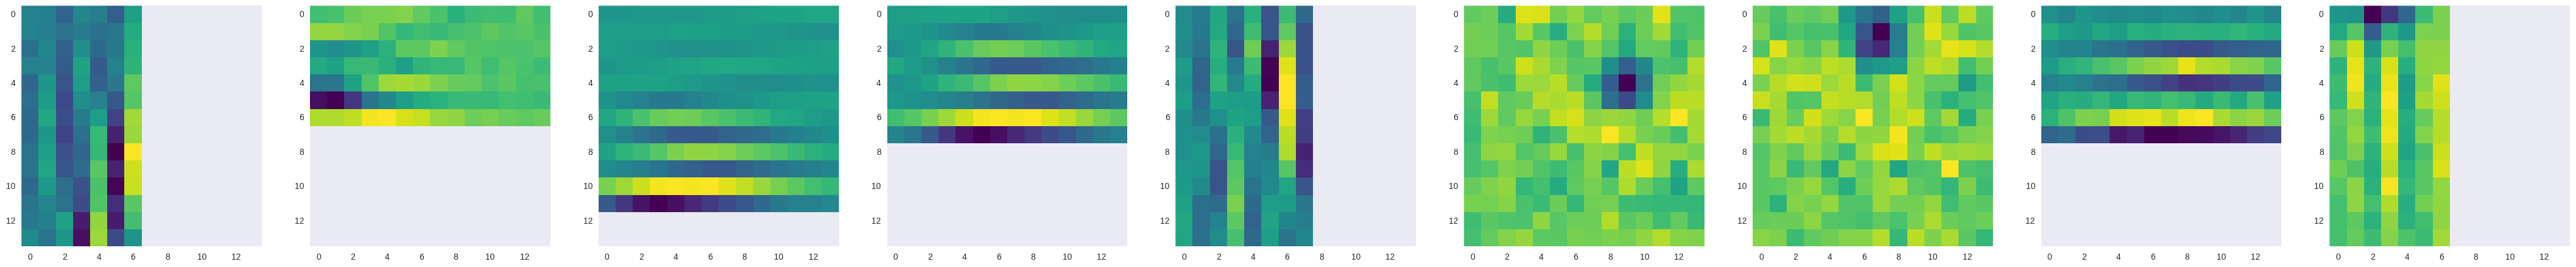

In [67]:
plt.figure(figsize=(6*len(outliers_z), 12))
for i in range(len(outliers_z)):
    patch = get_patch_zackay(outliers_z[i:i+1]['Y_IMAGE'], 
                              outliers_z[i:i+1]['X_IMAGE'], 
                              int(outliers_z[i:i+1]['image_id']))
    plt.subplot(1, len(outliers_z), i+1)
    plt.grid()
    plt.imshow(patch, cmap='viridis', interpolation='none')